# guid propagation导向反向传播

In [1]:
# guid propagation
import torch,os
import torch.nn as nn

class GuidedPropo():
    def __init__(self, model,layer):
        self.model = model
        self.layer = layer
        self.model.eval()
        self.gradients = None  # 需要输出的热力图
        self.relu_forward_output = []  # 记录前行传播过程中，ReLU层的输出
        self._hook_layers()
        
    def _hook_layers(self):
        def relu_forward_hook_function(module, ten_in, ten_out):

            self.relu_forward_output.append(ten_out)
            
        def relu_backward_hook_function(module, grad_in, grad_out):
            last_relu_output = self.relu_forward_output[-1]
            # 正向传播时，ReLU输出大于0的位置设置为1， 小于0的位置设置为0
            # 反向传播时，使用这个mask对出入的梯度进行设置，满足guided propagation算法
            mask = last_relu_output[last_relu_output > 0] = 1
            # 输入梯度小于0的位置设置为0
            modified_grad_in = torch.clamp(grad_in[0], min=0.0)
            # 最终的输出梯度
            modified_grad_out = modified_grad_in * mask
            # 再次向后传播梯度时，要更新最后一层的ReLU
            del self.relu_forward_output[-1]
            # 返回值与grad_out类型相同，都是tuple
            return (modified_grad_out,)
        
        def conv_backward_hook_function(module, grad_in, grad_out):

            self.gradients = grad_in[0]
            
        for index, module in enumerate(list(self.layer), 1):
            if isinstance(module, nn.Conv2d) and index == 1:  # 第一层卷积层
                module.register_backward_hook(conv_backward_hook_function)
            elif isinstance(module, nn.ReLU):
                module.register_forward_hook(relu_forward_hook_function)
                module.register_backward_hook(relu_backward_hook_function)
                
    def generate_cam(self, input_image, target_class):
        # Forward pass.
        model_out = self.model(input_image)  # shape [1, 1000]
        # Target grad.
        one_hot_output = torch.zeros(size=(1, model_out.size(1)), dtype=torch.float32)  # shape [1, 1000]
#         one_hot_output[0][target_class] = 1
        one_hot_output[0][target_class] = 0.7+np.random.rand(1)[0]*0.3
        
        # Backward pass.
        model_out.backward(gradient=one_hot_output.cuda())
        # self.gradients.shape = [1, 3, 224, 224]
#         print(self.gradients.cpu().numpy())
        image_as_array = self.gradients.cpu().numpy()[0]
        
        return image_as_array


# 试验样本展示

In [3]:
# 试验样本
sorted(os.listdir(os.getcwd()[:18]+'Visualization/testimg'))

['.ipynb_checkpoints',
 'compensate_fake3D_1364.jpg',
 'compensate_fake3D_2856.jpg',
 'compensate_fake3D_3348.jpg',
 'compensate_fake3D_3781.jpg',
 'compensate_fake3D_7931.jpg',
 'compensate_fakeGAN_1364.jpg',
 'compensate_fakeGAN_2856.jpg',
 'compensate_fakeGAN_3348.jpg',
 'compensate_fakeGAN_3781.jpg',
 'compensate_fakeGAN_7931.jpg',
 'compensate_fuse1_15.jpg',
 'compensate_fuse1_3.jpg',
 'compensate_fuse1_5.jpg',
 'compensate_fuse1_7.jpg',
 'compensate_fuse1_90.jpg',
 'compensate_nege_1364.jpg',
 'compensate_nege_2856.jpg',
 'compensate_nege_3348.jpg',
 'compensate_nege_3781.jpg',
 'compensate_nege_7931.jpg',
 'compensate_posi_1364.jpg',
 'compensate_posi_2856.jpg',
 'compensate_posi_3348.jpg',
 'compensate_posi_3781.jpg',
 'compensate_posi_7931.jpg',
 'fake3D_1364.jpg',
 'fake3D_2856.jpg',
 'fake3D_3348.jpg',
 'fake3D_3781.jpg',
 'fake3D_7931.jpg',
 'fakeGAN_1364.jpg',
 'fakeGAN_2856.jpg',
 'fakeGAN_3348.jpg',
 'fakeGAN_3781.jpg',
 'fakeGAN_7931.jpg',
 'fuse1_15.jpg',
 'fuse1_3.jpg

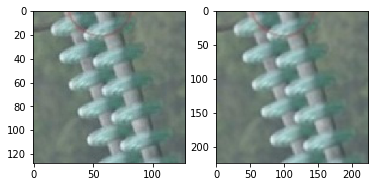

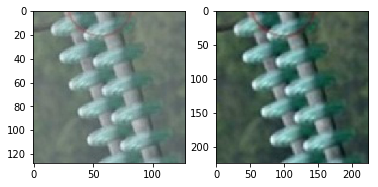

In [4]:
# 准备数据
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

image_path = 'testimg/posi_2856.jpg'
image_as_pil = Image.open(image_path)  # PIL type image


# image transform
transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.45255, 0.47114, 0.41886], std=[0.199, 0.191, 0.223])

])

# Image as tensor
image_as_tensor = transform(image_as_pil)
input_image = image_as_tensor.unsqueeze(0)

plt.figure()
plt.subplot(1,2,1),plt.imshow(image_as_pil) # 原图
plt.subplot(1,2,2),plt.imshow(np.transpose(image_as_tensor.data.numpy(), (1, 2, 0))) # 初步处理
plt.show()

a = np.transpose(image_as_tensor.data.numpy(), (1, 2, 0))
# a = image_as_tensor.data.numpy()
Na = (a - np.min(a)) / (np.max(a) - np.min(a))
plt.figure()
plt.subplot(1,2,1),plt.imshow(image_as_pil) # 原图
plt.subplot(1,2,2),plt.imshow(Na) # 初步处理
plt.show()

# 导向反向传播直接结果与可视化结果

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


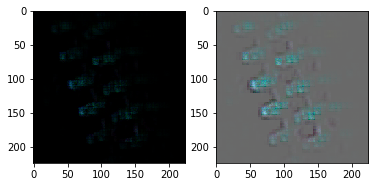

In [6]:
# guid backwardprop
from torchvision import models
from torch.autograd import Variable

# 前向网络
# model = models.alexnet(pretrained=True).cuda()
# model = models.DenseNet().cuda()
model = torch.load('alex_epoch_500.pkl').cuda()

# 反向梯度
guided_cam = GuidedPropo(model,model.features)
input_image_var = Variable(input_image.cuda(), requires_grad=True)
image_as_array = guided_cam.generate_cam(input_image_var,0)
                                         
# 图像归一化
image_for_show = (image_as_array - np.min(image_as_array)) / (np.max(image_as_array) - np.min(image_as_array))

plt.figure()
plt.subplot(1,2,1),plt.imshow(image_as_array.transpose((1,2,0))) # guid backprop
plt.subplot(1,2,2),plt.imshow(np.transpose(image_for_show, (1, 2, 0))) # guid backprop 归一化
plt.show()

(150528,)
238.00000101327896 65.0000037252903


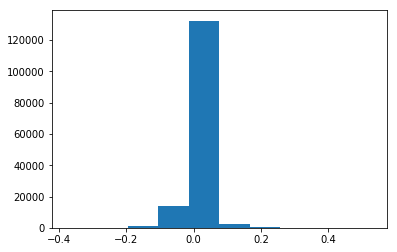

In [7]:
# 导向反向传播直接结果的直方统计
import pandas as pd
print(image_as_array.reshape(-1).shape)
print(np.max(a)*255,np.min(a)*255)
plt.hist(image_as_array.reshape(-1))
plt.show()
# df = pd.DataFrame(image_as_array.reshape(-1))
# df.to_csv('2.csv',index=False )

# 补偿操作

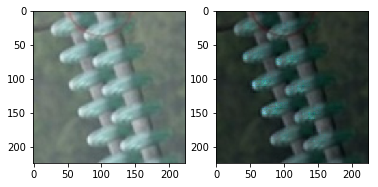

In [10]:
# 补偿前后对比
import cv2
a = np.transpose(image_as_tensor.data.numpy(), (1, 2, 0))
Na = (a - np.min(a)) / (np.max(a) - np.min(a))
b = image_as_array.transpose((1,2,0))

a,b = image_as_tensor.data.numpy().transpose(1,2,0),image_as_array.transpose(1,2,0)
cam_gb = np.multiply(a, np.exp(b))
# cam_gb = np.multiply(image_as_tensor.data.numpy(), image_for_show)
Ncam_gb = (cam_gb - np.min(cam_gb)) / (np.max(cam_gb) - np.min(cam_gb)) # 归一化指数函数


plt.figure()
plt.subplot(1,2,1),plt.imshow(a) # 原图
plt.subplot(1,2,2),plt.imshow(Ncam_gb) # 补偿后
plt.show()

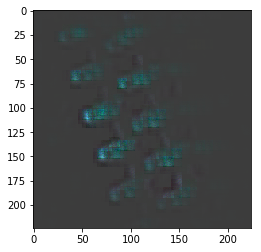

In [12]:
# 补偿前后的差异可视化
c = cam_gb-a
c = (c - np.min(c)) / (np.max(c) - np.min(c))
plt.imshow(c)
plt.show()